---
title: Glider Optimization
module: optimization
---

In [1]:
%matplotlib inline
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import scipy
#import logging
#pynamics.logger.setLevel(logging.ERROR)
#pynamics.system.logger.setLevel(logging.ERROR)
import numpy
import matplotlib.pyplot as plt
plt.ion()

In [2]:
from math import pi, sin, cos

In [3]:
system = System()
pynamics.set_system(__name__,system)

In [4]:
tinitial = 0
tfinal = 5
tstep = 1/30
t = numpy.r_[tinitial:tfinal:tstep]

ang_ini = 0
v=1



In [5]:
x,x_d,x_dd = Differentiable('x',ini=[0,v*cos(ang_ini*pi/180)])
y,y_d,y_dd = Differentiable('y',ini=[1,v*sin(ang_ini*pi/180)])
z,z_d,z_dd = Differentiable('z',ini=[0,0])

qA,qA_d,qA_dd = Differentiable('qA',ini=[0,0])
qB,qB_d,qB_dd = Differentiable('qB',ini=[0,0])
qC,qC_d,qC_dd = Differentiable('qC',ini=[ang_ini*pi/180,0])

In [6]:

# mC = Constant(0,'mC')
g = Constant(9.81,'g')
I_11=Constant(6e-3,'I_11')
rho = Constant(1.292,'rho')
r = Constant(0,'r')
# Sw = Constant(.1,'Sw')
# Se = Constant(.025,'Se')
l = Constant(.35,'l')
lw = Constant(-.03,'lw')
le = Constant(.04,'le')
qE = Constant(3*pi/180,'qE')

In [7]:
ini = system.get_ini()

N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
E = Frame('E',system)

system.set_newtonian(N)
A.rotate_fixed_axis(N,[1,0,0],qA,system)
B.rotate_fixed_axis(A,[0,1,0],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)
E.rotate_fixed_axis(C,[0,0,1],-qE,system)


In [8]:
pCcm=x*N.x+y*N.y+z*N.z
pCcp=pCcm-lw*C.x

mC = pi*r**2*.1

pC1 = pCcm
pC2 = pCcm-l*C.x
pE = pC2-le*E.x

vcm = pCcm.time_derivative()

In [9]:

vcm = pCcm.time_derivative()

IC = Dyadic.build(C,I_11,I_11,I_11)

Body('BodyC',C,pCcm,mC,IC)

Area = 2*pi*r**2
Area_f = 2*pi*.001
#Area_f = 0


In [10]:
vcp=pCcp.time_derivative()
f_aero_C = rho * vcp.length()*(vcp.dot(C.y))*Area*C.y
f_aero_Cf = rho * vcp.length()*(vcp.dot(C.x))*Area_f *C.x

ve=pE.time_derivative()
f_aero_E = rho * ve.length()*(ve.dot(E.y))*Area*E.y
f_aero_Ef = rho * ve.length()*(ve.dot(E.x))*Area_f*E.x


In [11]:
system.addforcegravity(-g*N.y)
system.addforce(-f_aero_C,vcp)
system.addforce(-f_aero_E,ve)
system.addforce(-f_aero_Cf,vcp)
system.addforce(-f_aero_Ef,ve)


In [12]:
points = [pC1,pC2]

In [13]:
f,ma = system.getdynamics()
func1 = system.state_space_post_invert(f,ma)

2022-04-14 14:50:28,174 - pynamics.system - INFO - getting dynamic equations
2022-04-14 14:50:28,467 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-14 14:50:29,429 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-14 14:50:30,135 - pynamics.system - INFO - done solving a = f/m and creating function


In [14]:

PE = system.getPEGravity(0*N.x)
KE = system.get_KE()

E = KE-PE
E

0.5*I_11*qC_d*(qA_d*sin(qB) + qC_d) + 0.314159265358979*g*r**2*y + 0.15707963267949*r**2*(x_d**2 + y_d**2 + z_d**2) + 0.5*qA_d*(I_11*(qA_d*sin(qB) + qC_d)*sin(qB) - I_11*(-qA_d*sin(qC)*cos(qB) + qB_d*cos(qC))*sin(qC)*cos(qB) + I_11*(qA_d*cos(qB)*cos(qC) + qB_d*sin(qC))*cos(qB)*cos(qC)) + 0.5*qB_d*(I_11*(-qA_d*sin(qC)*cos(qB) + qB_d*cos(qC))*cos(qC) + I_11*(qA_d*cos(qB)*cos(qC) + qB_d*sin(qC))*sin(qC))

In [15]:
PE

-0.314159265358979*g*r**2*y

In [16]:
def run(args):
    my_r = args[0]
    constants = system.constant_values.copy()
    constants[r] = my_r
    
    states=pynamics.integration.integrate_odeint(func1,ini,t, args=({'constants':constants},))
        
    return states


In [17]:
system.get_state_variables()

[x, y, z, qA, qB, qC, x_d, y_d, z_d, qA_d, qB_d, qC_d]

In [18]:
def measure_perf(args):
    print('r: ',args[0])
   # if args[0]>1:
   #     return 1000
   # if args[0]<=0:
   #     return 1000
    try:
        states = run(args)
        perf = (1/states[-1,0])**2 + 5*(states[-1,1])**2 
        return perf
    except scipy.linalg.LinAlgError:
        return 1000


2022-04-14 14:50:30,271 - pynamics.integration - INFO - beginning integration
2022-04-14 14:50:30,272 - pynamics.system - INFO - integration at time 0000.00


r:  0.1


2022-04-14 14:50:33,779 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:33,781 - pynamics.integration - INFO - beginning integration
2022-04-14 14:50:33,922 - pynamics.system - INFO - integration at time 0000.01


r:  0.325


2022-04-14 14:50:37,229 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:37,231 - pynamics.integration - INFO - beginning integration


r:  0.55


2022-04-14 14:50:37,545 - pynamics.system - INFO - integration at time 0000.04
2022-04-14 14:50:41,030 - pynamics.system - INFO - integration at time 0001.04
2022-04-14 14:50:44,278 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:44,279 - pynamics.integration - INFO - beginning integration
2022-04-14 14:50:44,447 - pynamics.system - INFO - integration at time 0000.01


r:  0.775


2022-04-14 14:50:47,857 - pynamics.system - INFO - integration at time 0004.81
2022-04-14 14:50:47,941 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:47,943 - pynamics.integration - INFO - beginning integration


r:  1.0


2022-04-14 14:50:51,248 - pynamics.system - INFO - integration at time 0002.72
2022-04-14 14:50:52,408 - pynamics.integration - INFO - finished integration


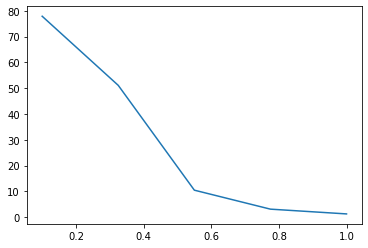

In [19]:
yy = []    
xx = numpy.r_[0.1:1:5j]
for ii in xx:
    yy.append(measure_perf([ii]))
    
yy = numpy.array(yy)
plt.plot(xx,yy)

In [20]:
result = scipy.optimize.minimize(measure_perf,[.5],method='powell',bounds=[(.1,1)])
best = result.x

2022-04-14 14:50:52,615 - pynamics.integration - INFO - beginning integration


r:  0.5


2022-04-14 14:50:54,808 - pynamics.system - INFO - integration at time 0003.79
2022-04-14 14:50:54,988 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:54,989 - pynamics.integration - INFO - beginning integration


r:  0.4437694101250946


2022-04-14 14:50:58,132 - pynamics.system - INFO - integration at time 0001.21
2022-04-14 14:50:59,976 - pynamics.integration - INFO - finished integration
2022-04-14 14:50:59,977 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749052


2022-04-14 14:51:01,431 - pynamics.system - INFO - integration at time 0000.95
2022-04-14 14:51:03,260 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:03,261 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:51:04,747 - pynamics.system - INFO - integration at time 0001.08
2022-04-14 14:51:06,518 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:06,520 - pynamics.integration - INFO - beginning integration


r:  0.7877560928849625


2022-04-14 14:51:07,993 - pynamics.system - INFO - integration at time 0000.91
2022-04-14 14:51:10,593 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:10,595 - pynamics.integration - INFO - beginning integration


r:  0.8688260514978312


2022-04-14 14:51:11,322 - pynamics.system - INFO - integration at time 0000.19
2022-04-14 14:51:14,261 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:14,262 - pynamics.integration - INFO - beginning integration


r:  0.9189300413871313


2022-04-14 14:51:14,717 - pynamics.system - INFO - integration at time 0000.07
2022-04-14 14:51:18,409 - pynamics.system - INFO - integration at time 0004.59
2022-04-14 14:51:18,712 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:18,714 - pynamics.integration - INFO - beginning integration


r:  0.9498960101106999


2022-04-14 14:51:21,806 - pynamics.system - INFO - integration at time 0003.38
2022-04-14 14:51:22,906 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:22,907 - pynamics.integration - INFO - beginning integration


r:  0.9690340312764314


2022-04-14 14:51:25,154 - pynamics.system - INFO - integration at time 0002.05
2022-04-14 14:51:27,389 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:27,391 - pynamics.integration - INFO - beginning integration


r:  0.9808619788342684


2022-04-14 14:51:28,344 - pynamics.system - INFO - integration at time 0000.28
2022-04-14 14:51:31,537 - pynamics.system - INFO - integration at time 0003.54
2022-04-14 14:51:32,389 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:32,390 - pynamics.integration - INFO - beginning integration


r:  0.988172052442163


2022-04-14 14:51:34,817 - pynamics.system - INFO - integration at time 0001.81
2022-04-14 14:51:36,730 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:36,731 - pynamics.integration - INFO - beginning integration


r:  0.9926899263921054


2022-04-14 14:51:38,187 - pynamics.system - INFO - integration at time 0000.83
2022-04-14 14:51:41,823 - pynamics.system - INFO - integration at time 0004.72
2022-04-14 14:51:42,172 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:42,174 - pynamics.integration - INFO - beginning integration


r:  0.9954821260500576


2022-04-14 14:51:45,390 - pynamics.system - INFO - integration at time 0002.99
2022-04-14 14:51:46,665 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:46,666 - pynamics.integration - INFO - beginning integration


r:  0.9972078003420479


2022-04-14 14:51:48,710 - pynamics.system - INFO - integration at time 0001.72
2022-04-14 14:51:50,554 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:50,556 - pynamics.integration - INFO - beginning integration


r:  0.9982743257080098


2022-04-14 14:51:51,943 - pynamics.system - INFO - integration at time 0001.15
2022-04-14 14:51:54,157 - pynamics.integration - INFO - finished integration
2022-04-14 14:51:54,159 - pynamics.integration - INFO - beginning integration


r:  0.9989334746340381


2022-04-14 14:51:55,382 - pynamics.system - INFO - integration at time 0000.41
2022-04-14 14:51:59,130 - pynamics.system - INFO - integration at time 0004.25
2022-04-14 14:52:00,082 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:00,084 - pynamics.integration - INFO - beginning integration


r:  0.9993408510739716


2022-04-14 14:52:02,844 - pynamics.system - INFO - integration at time 0001.87
2022-04-14 14:52:04,428 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:04,430 - pynamics.integration - INFO - beginning integration


r:  0.9995926235600665


2022-04-14 14:52:06,139 - pynamics.system - INFO - integration at time 0001.16
2022-04-14 14:52:09,214 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:09,216 - pynamics.integration - INFO - beginning integration
2022-04-14 14:52:09,301 - pynamics.system - INFO - integration at time 0000.00


r:  0.9997482275139051


2022-04-14 14:52:12,676 - pynamics.system - INFO - integration at time 0002.28
2022-04-14 14:52:14,724 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:14,725 - pynamics.integration - INFO - beginning integration


r:  0.9998443960461614


2022-04-14 14:52:15,802 - pynamics.system - INFO - integration at time 0000.56
2022-04-14 14:52:18,645 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:18,646 - pynamics.integration - INFO - beginning integration


r:  0.9999038314677438


2022-04-14 14:52:18,987 - pynamics.system - INFO - integration at time 0000.03
2022-04-14 14:52:22,310 - pynamics.system - INFO - integration at time 0003.51
2022-04-14 14:52:23,537 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:23,539 - pynamics.integration - INFO - beginning integration


r:  0.9999405645784174


2022-04-14 14:52:25,556 - pynamics.system - INFO - integration at time 0001.32
2022-04-14 14:52:28,448 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:28,450 - pynamics.integration - INFO - beginning integration


r:  1.4998811291568348


2022-04-14 14:52:28,668 - pynamics.system - INFO - integration at time 0000.01
2022-04-14 14:52:31,773 - pynamics.system - INFO - integration at time 0003.57
2022-04-14 14:52:33,645 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:33,646 - pynamics.integration - INFO - beginning integration


r:  0.44376941012509463


2022-04-14 14:52:34,887 - pynamics.system - INFO - integration at time 0000.83
2022-04-14 14:52:37,994 - pynamics.system - INFO - integration at time 0003.52
2022-04-14 14:52:38,415 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:38,416 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749053


2022-04-14 14:52:41,082 - pynamics.system - INFO - integration at time 0004.16
2022-04-14 14:52:41,459 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:41,461 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:52:44,200 - pynamics.system - INFO - integration at time 0004.35
2022-04-14 14:52:44,591 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:44,592 - pynamics.integration - INFO - beginning integration


r:  0.7877560835773538


2022-04-14 14:52:47,335 - pynamics.system - INFO - integration at time 0003.67
2022-04-14 14:52:48,207 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:48,208 - pynamics.integration - INFO - beginning integration


r:  0.8688260457454127


2022-04-14 14:52:50,409 - pynamics.system - INFO - integration at time 0002.81
2022-04-14 14:52:51,696 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:51,698 - pynamics.integration - INFO - beginning integration


r:  0.9189300378319412


2022-04-14 14:52:53,487 - pynamics.system - INFO - integration at time 0001.38
2022-04-14 14:52:55,719 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:55,720 - pynamics.integration - INFO - beginning integration


r:  0.9498960079134715


2022-04-14 14:52:56,564 - pynamics.system - INFO - integration at time 0000.34
2022-04-14 14:52:59,522 - pynamics.integration - INFO - finished integration
2022-04-14 14:52:59,523 - pynamics.integration - INFO - beginning integration


r:  0.9690340299184697


2022-04-14 14:52:59,739 - pynamics.system - INFO - integration at time 0000.01
2022-04-14 14:53:02,883 - pynamics.system - INFO - integration at time 0003.49
2022-04-14 14:53:03,639 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:03,640 - pynamics.integration - INFO - beginning integration


r:  0.9808619779950019


2022-04-14 14:53:05,949 - pynamics.system - INFO - integration at time 0001.35
2022-04-14 14:53:08,286 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:08,287 - pynamics.integration - INFO - beginning integration


r:  0.9881720519234678


2022-04-14 14:53:08,993 - pynamics.system - INFO - integration at time 0000.16
2022-04-14 14:53:12,107 - pynamics.system - INFO - integration at time 0004.57
2022-04-14 14:53:12,467 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:12,468 - pynamics.integration - INFO - beginning integration


r:  0.9926899260715342


2022-04-14 14:53:15,225 - pynamics.system - INFO - integration at time 0002.37
2022-04-14 14:53:17,200 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:17,201 - pynamics.integration - INFO - beginning integration


r:  0.9954821258519336


2022-04-14 14:53:18,328 - pynamics.system - INFO - integration at time 0000.73
2022-04-14 14:53:21,037 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:21,039 - pynamics.integration - INFO - beginning integration


r:  0.9972078002196005


2022-04-14 14:53:21,514 - pynamics.system - INFO - integration at time 0000.06
2022-04-14 14:53:24,694 - pynamics.system - INFO - integration at time 0004.82
2022-04-14 14:53:24,776 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:24,777 - pynamics.integration - INFO - beginning integration


r:  0.9982743256323331


2022-04-14 14:53:27,809 - pynamics.system - INFO - integration at time 0003.59
2022-04-14 14:53:28,453 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:28,454 - pynamics.integration - INFO - beginning integration


r:  0.9989334745872673


2022-04-14 14:53:30,950 - pynamics.system - INFO - integration at time 0001.81
2022-04-14 14:53:32,705 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:32,706 - pynamics.integration - INFO - beginning integration


r:  0.9993408510450658


2022-04-14 14:53:34,122 - pynamics.system - INFO - integration at time 0000.94
2022-04-14 14:53:37,388 - pynamics.system - INFO - integration at time 0004.53
2022-04-14 14:53:38,203 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:38,204 - pynamics.integration - INFO - beginning integration


r:  0.9995926235422017


2022-04-14 14:53:40,593 - pynamics.system - INFO - integration at time 0003.04
2022-04-14 14:53:41,916 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:41,917 - pynamics.integration - INFO - beginning integration


r:  0.9997482275028641


2022-04-14 14:53:43,853 - pynamics.system - INFO - integration at time 0001.12
2022-04-14 14:53:46,666 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:46,668 - pynamics.integration - INFO - beginning integration


r:  0.9998443960393376


2022-04-14 14:53:46,957 - pynamics.system - INFO - integration at time 0000.02
2022-04-14 14:53:50,100 - pynamics.system - INFO - integration at time 0004.39
2022-04-14 14:53:50,485 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:50,487 - pynamics.integration - INFO - beginning integration


r:  0.9999038314635265


2022-04-14 14:53:53,194 - pynamics.system - INFO - integration at time 0002.37
2022-04-14 14:53:54,844 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:54,846 - pynamics.integration - INFO - beginning integration


r:  0.999940564575811


2022-04-14 14:53:56,269 - pynamics.system - INFO - integration at time 0001.03
2022-04-14 14:53:59,010 - pynamics.integration - INFO - finished integration
2022-04-14 14:53:59,011 - pynamics.integration - INFO - beginning integration


r:  0.9999632668877154


2022-04-14 14:53:59,360 - pynamics.system - INFO - integration at time 0000.03
2022-04-14 14:54:02,525 - pynamics.system - INFO - integration at time 0004.45
2022-04-14 14:54:02,948 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:02,951 - pynamics.integration - INFO - beginning integration


r:  0.9999799315735381


2022-04-14 14:54:05,541 - pynamics.system - INFO - integration at time 0003.31
2022-04-14 14:54:06,972 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:06,974 - pynamics.integration - INFO - beginning integration


r:  0.4437694101250945


2022-04-14 14:54:08,492 - pynamics.system - INFO - integration at time 0000.93
2022-04-14 14:54:11,436 - pynamics.system - INFO - integration at time 0004.31
2022-04-14 14:54:11,490 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:11,492 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749052


2022-04-14 14:54:14,397 - pynamics.system - INFO - integration at time 0004.96
2022-04-14 14:54:14,405 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:14,406 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:54:17,372 - pynamics.system - INFO - integration at time 0004.95
2022-04-14 14:54:17,382 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:17,384 - pynamics.integration - INFO - beginning integration


r:  0.7877560936006085


2022-04-14 14:54:20,517 - pynamics.system - INFO - integration at time 0003.67
2022-04-14 14:54:21,055 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:21,056 - pynamics.integration - INFO - beginning integration


r:  0.8688260519401247


2022-04-14 14:54:23,640 - pynamics.system - INFO - integration at time 0003.21
2022-04-14 14:54:24,361 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:24,363 - pynamics.integration - INFO - beginning integration


r:  0.9189300416604838


2022-04-14 14:54:26,855 - pynamics.system - INFO - integration at time 0003.04
2022-04-14 14:54:27,798 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:27,800 - pynamics.integration - INFO - beginning integration


r:  0.949896010279641


2022-04-14 14:54:29,989 - pynamics.system - INFO - integration at time 0001.91
2022-04-14 14:54:31,470 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:31,472 - pynamics.integration - INFO - beginning integration


r:  0.9690340313808428


2022-04-14 14:54:33,036 - pynamics.system - INFO - integration at time 0001.40
2022-04-14 14:54:35,285 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:35,286 - pynamics.integration - INFO - beginning integration


r:  0.9808619788987982


2022-04-14 14:54:36,063 - pynamics.system - INFO - integration at time 0000.23
2022-04-14 14:54:39,075 - pynamics.system - INFO - integration at time 0003.59
2022-04-14 14:54:40,298 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:40,299 - pynamics.integration - INFO - beginning integration


r:  0.9881720524820445


2022-04-14 14:54:42,119 - pynamics.system - INFO - integration at time 0001.33
2022-04-14 14:54:43,987 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:43,988 - pynamics.integration - INFO - beginning integration


r:  0.9926899264167536


2022-04-14 14:54:45,170 - pynamics.system - INFO - integration at time 0000.81
2022-04-14 14:54:47,966 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:47,967 - pynamics.integration - INFO - beginning integration


r:  0.995482126065291


2022-04-14 14:54:48,194 - pynamics.system - INFO - integration at time 0000.01
2022-04-14 14:54:51,210 - pynamics.system - INFO - integration at time 0003.34
2022-04-14 14:54:52,534 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:52,535 - pynamics.integration - INFO - beginning integration


r:  0.9972078003514626


2022-04-14 14:54:54,238 - pynamics.system - INFO - integration at time 0001.46
2022-04-14 14:54:56,077 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:56,078 - pynamics.integration - INFO - beginning integration


r:  0.9982743257138283


2022-04-14 14:54:57,262 - pynamics.system - INFO - integration at time 0000.86
2022-04-14 14:54:59,577 - pynamics.integration - INFO - finished integration
2022-04-14 14:54:59,578 - pynamics.integration - INFO - beginning integration


r:  0.9989334746376343


2022-04-14 14:55:00,271 - pynamics.system - INFO - integration at time 0000.16
2022-04-14 14:55:02,921 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:02,922 - pynamics.integration - INFO - beginning integration


r:  0.9993408510761942


2022-04-14 14:55:03,300 - pynamics.system - INFO - integration at time 0000.04
2022-04-14 14:55:06,304 - pynamics.system - INFO - integration at time 0003.28
2022-04-14 14:55:07,118 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:07,120 - pynamics.integration - INFO - beginning integration


r:  0.9995926235614401


2022-04-14 14:55:09,291 - pynamics.system - INFO - integration at time 0002.13
2022-04-14 14:55:11,066 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:11,067 - pynamics.integration - INFO - beginning integration


r:  0.9997482275147541


2022-04-14 14:55:12,308 - pynamics.system - INFO - integration at time 0000.92
2022-04-14 14:55:15,248 - pynamics.system - INFO - integration at time 0004.19
2022-04-14 14:55:15,588 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:15,589 - pynamics.integration - INFO - beginning integration


r:  0.999844396046686


2022-04-14 14:55:18,203 - pynamics.system - INFO - integration at time 0003.71
2022-04-14 14:55:19,359 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:19,361 - pynamics.integration - INFO - beginning integration


r:  0.999903831468068


2022-04-14 14:55:21,182 - pynamics.system - INFO - integration at time 0001.31
2022-04-14 14:55:23,750 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:23,752 - pynamics.integration - INFO - beginning integration


r:  0.9999405645786179


2022-04-14 14:55:24,259 - pynamics.system - INFO - integration at time 0000.08
2022-04-14 14:55:27,268 - pynamics.system - INFO - integration at time 0004.70
2022-04-14 14:55:27,641 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:27,642 - pynamics.integration - INFO - beginning integration


r:  0.9999632668894501


2022-04-14 14:55:30,226 - pynamics.system - INFO - integration at time 0002.92
2022-04-14 14:55:31,315 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:31,316 - pynamics.integration - INFO - beginning integration


r:  0.9999772976891678


2022-04-14 14:55:33,159 - pynamics.system - INFO - integration at time 0001.94
2022-04-14 14:55:35,071 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:35,073 - pynamics.integration - INFO - beginning integration


r:  0.9999859692002825


2022-04-14 14:55:36,086 - pynamics.system - INFO - integration at time 0000.58
2022-04-14 14:55:38,863 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:38,864 - pynamics.integration - INFO - beginning integration
2022-04-14 14:55:39,014 - pynamics.system - INFO - integration at time 0000.01


r:  0.9999913284888853


2022-04-14 14:55:42,021 - pynamics.system - INFO - integration at time 0004.16
2022-04-14 14:55:42,674 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:42,675 - pynamics.integration - INFO - beginning integration


r:  0.9999946407113972


2022-04-14 14:55:45,062 - pynamics.system - INFO - integration at time 0001.58
2022-04-14 14:55:47,527 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:47,529 - pynamics.integration - INFO - beginning integration


r:  0.999996687777488


2022-04-14 14:55:48,079 - pynamics.system - INFO - integration at time 0000.10
2022-04-14 14:55:51,097 - pynamics.system - INFO - integration at time 0003.37
2022-04-14 14:55:52,183 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:52,185 - pynamics.integration - INFO - beginning integration


r:  0.9999979529339093


2022-04-14 14:55:54,094 - pynamics.system - INFO - integration at time 0001.79
2022-04-14 14:55:55,518 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:55,519 - pynamics.integration - INFO - beginning integration


r:  0.9999987348435787


2022-04-14 14:55:57,089 - pynamics.system - INFO - integration at time 0001.27
2022-04-14 14:55:59,053 - pynamics.integration - INFO - finished integration
2022-04-14 14:55:59,055 - pynamics.integration - INFO - beginning integration


r:  0.9999992180903305


2022-04-14 14:56:00,105 - pynamics.system - INFO - integration at time 0000.64
2022-04-14 14:56:03,005 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:03,007 - pynamics.integration - INFO - beginning integration
2022-04-14 14:56:03,133 - pynamics.system - INFO - integration at time 0000.00


r:  0.9999995167532482


2022-04-14 14:56:06,075 - pynamics.system - INFO - integration at time 0003.79
2022-04-14 14:56:07,014 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:07,015 - pynamics.integration - INFO - beginning integration


r:  0.9999997013370824


2022-04-14 14:56:09,055 - pynamics.system - INFO - integration at time 0001.53
2022-04-14 14:56:11,405 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:11,406 - pynamics.integration - INFO - beginning integration


r:  0.9999998154161658


2022-04-14 14:56:12,017 - pynamics.system - INFO - integration at time 0000.13
2022-04-14 14:56:14,982 - pynamics.system - INFO - integration at time 0004.42
2022-04-14 14:56:15,348 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:15,349 - pynamics.integration - INFO - beginning integration


r:  0.9999997788400657


2022-04-14 14:56:17,965 - pynamics.system - INFO - integration at time 0002.99
2022-04-14 14:56:19,000 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:19,001 - pynamics.integration - INFO - beginning integration


r:  0.999999761022426


2022-04-14 14:56:20,951 - pynamics.system - INFO - integration at time 0001.70
2022-04-14 14:56:22,800 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:22,801 - pynamics.integration - INFO - beginning integration


r:  0.9999997887178371


2022-04-14 14:56:23,992 - pynamics.system - INFO - integration at time 0000.72
2022-04-14 14:56:26,638 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:26,639 - pynamics.integration - INFO - beginning integration


r:  0.999999772034333


2022-04-14 14:56:27,013 - pynamics.system - INFO - integration at time 0000.04
2022-04-14 14:56:29,953 - pynamics.system - INFO - integration at time 0004.87
2022-04-14 14:56:30,171 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:30,172 - pynamics.integration - INFO - beginning integration


r:  0.9999997678281588


2022-04-14 14:56:32,899 - pynamics.system - INFO - integration at time 0003.18
2022-04-14 14:56:34,103 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:34,104 - pynamics.integration - INFO - beginning integration


r:  0.9999997746338916


2022-04-14 14:56:35,889 - pynamics.system - INFO - integration at time 0001.52
2022-04-14 14:56:38,274 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:38,275 - pynamics.integration - INFO - beginning integration


r:  0.9999997704277174


2022-04-14 14:56:38,834 - pynamics.system - INFO - integration at time 0000.11
2022-04-14 14:56:41,762 - pynamics.system - INFO - integration at time 0004.74
2022-04-14 14:56:41,891 - pynamics.integration - INFO - finished integration


In [21]:
states = run([best])

2022-04-14 14:56:41,896 - pynamics.integration - INFO - beginning integration
<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array([[0.314159265358979*r**2, 0, 0, 0, 0, 0], [0, 0.314159265358979*r**2, 0, 0, 0, 0], [0, 0, 0.314159265358979*r**2, 0, 0, 0], [0, 0, 0, I_11*sin(qB)**2 + (I_11*sin(qC)**2*cos(qB) + I_11*cos(qB)*cos(qC)**2)*cos(qB), 0, I_11*sin(qB)], [0, 0, 0, 0, I_11*sin(qC)**2 + I_11*cos(qC)**2, 0], [0, 0, 0, I_11*sin(qB), 0, I_11]])
<lambdifygenerated-2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  retur

2022-04-14 14:56:45,004 - pynamics.system - INFO - integration at time 0003.93
2022-04-14 14:56:45,737 - pynamics.integration - INFO - finished integration


2022-04-14 14:56:45,752 - pynamics.output - INFO - calculating outputs
2022-04-14 14:56:45,757 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

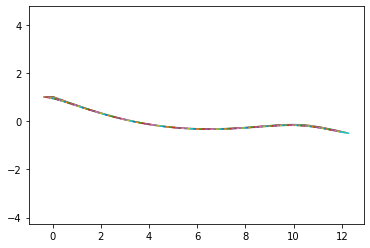

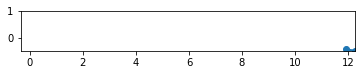

In [22]:
po = PointsOutput(points,system)
po.calc(states,t)
po.plot_time()
po.animate(fps = 30, movie_name='glider.mp4',lw=2,marker='o')

In [23]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(po.anim.to_html5_video())

In [24]:
o1 = Output([E],system,system.constant_values)

In [25]:
def maximize_energy(args):
    print('r: ',args[0])
   # if args[0]>1:
   #     return 1000
   # if args[0]<=0:
   #     return 1000
    try:
        states = run(args)
        y = o1.calc(states,t)
        perf = 1/y[-1] 
        return perf
    except scipy.linalg.LinAlgError:
        return 1000

In [26]:
#best=.1
result = scipy.optimize.minimize(maximize_energy,[.5],method='powell',bounds=[(.1,1)])
best = result.x


2022-04-14 14:56:52,210 - pynamics.integration - INFO - beginning integration


r:  0.5


2022-04-14 14:56:54,493 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:54,494 - pynamics.output - INFO - calculating outputs
2022-04-14 14:56:54,499 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:56:54,501 - pynamics.integration - INFO - beginning integration


r:  0.4437694101250946


2022-04-14 14:56:54,723 - pynamics.system - INFO - integration at time 0000.03
2022-04-14 14:56:57,920 - pynamics.system - INFO - integration at time 0001.40
2022-04-14 14:56:59,336 - pynamics.integration - INFO - finished integration
2022-04-14 14:56:59,337 - pynamics.output - INFO - calculating outputs
2022-04-14 14:56:59,342 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:56:59,343 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749052


2022-04-14 14:57:01,119 - pynamics.system - INFO - integration at time 0001.67
2022-04-14 14:57:02,468 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:02,470 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:02,475 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:02,476 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:57:04,293 - pynamics.system - INFO - integration at time 0001.83
2022-04-14 14:57:05,668 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:05,669 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:05,674 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:05,675 - pynamics.integration - INFO - beginning integration


r:  0.7312069994504087


2022-04-14 14:57:07,521 - pynamics.system - INFO - integration at time 0001.91
2022-04-14 14:57:08,733 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:08,734 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:08,738 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:08,739 - pynamics.integration - INFO - beginning integration


r:  0.7914957689712718


2022-04-14 14:57:10,693 - pynamics.system - INFO - integration at time 0001.56
2022-04-14 14:57:12,320 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:12,322 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:12,326 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:12,327 - pynamics.integration - INFO - beginning integration


r:  0.8069181956411859


2022-04-14 14:57:13,854 - pynamics.system - INFO - integration at time 0000.95
2022-04-14 14:57:16,083 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:16,084 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:16,089 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:16,091 - pynamics.integration - INFO - beginning integration


r:  0.8806688822970953


2022-04-14 14:57:17,067 - pynamics.system - INFO - integration at time 0000.52
2022-04-14 14:57:20,252 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:20,253 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:20,258 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:20,259 - pynamics.integration - INFO - beginning integration
2022-04-14 14:57:20,297 - pynamics.system - INFO - integration at time 0000.00


r:  0.8099243266534977


2022-04-14 14:57:23,515 - pynamics.system - INFO - integration at time 0004.30
2022-04-14 14:57:23,950 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:23,951 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:23,955 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:23,956 - pynamics.integration - INFO - beginning integration


r:  0.8104735739012696


2022-04-14 14:57:26,743 - pynamics.system - INFO - integration at time 0003.23
2022-04-14 14:57:28,073 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:28,074 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:28,079 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:28,080 - pynamics.integration - INFO - beginning integration


r:  0.8101257234702286


2022-04-14 14:57:29,944 - pynamics.system - INFO - integration at time 0002.05
2022-04-14 14:57:31,327 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:31,328 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:31,333 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:31,335 - pynamics.integration - INFO - beginning integration


r:  0.8101845153810388


2022-04-14 14:57:33,136 - pynamics.system - INFO - integration at time 0002.14
2022-04-14 14:57:34,249 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:34,249 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:34,255 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:34,256 - pynamics.integration - INFO - beginning integration


r:  0.8100699669623956


2022-04-14 14:57:36,331 - pynamics.system - INFO - integration at time 0002.62
2022-04-14 14:57:37,646 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:37,647 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:37,653 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:37,654 - pynamics.integration - INFO - beginning integration


r:  1.1202514469404572


2022-04-14 14:57:39,494 - pynamics.system - INFO - integration at time 0001.31
2022-04-14 14:57:42,152 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:42,153 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:42,159 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:42,160 - pynamics.integration - INFO - beginning integration


r:  0.44376941012509463


2022-04-14 14:57:42,697 - pynamics.system - INFO - integration at time 0000.26
2022-04-14 14:57:45,871 - pynamics.system - INFO - integration at time 0001.89
2022-04-14 14:57:47,068 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:47,069 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:47,074 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:47,076 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749052


2022-04-14 14:57:49,033 - pynamics.system - INFO - integration at time 0001.97
2022-04-14 14:57:50,172 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:50,173 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:50,178 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:50,179 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:57:52,161 - pynamics.system - INFO - integration at time 0002.33
2022-04-14 14:57:53,314 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:53,315 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:53,320 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:53,321 - pynamics.integration - INFO - beginning integration


r:  0.7312069520431239


2022-04-14 14:57:55,293 - pynamics.system - INFO - integration at time 0002.40
2022-04-14 14:57:56,173 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:56,174 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:56,178 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:56,179 - pynamics.integration - INFO - beginning integration


r:  0.7914926866091372


2022-04-14 14:57:58,460 - pynamics.system - INFO - integration at time 0002.06
2022-04-14 14:57:59,804 - pynamics.integration - INFO - finished integration
2022-04-14 14:57:59,804 - pynamics.output - INFO - calculating outputs
2022-04-14 14:57:59,809 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:57:59,810 - pynamics.integration - INFO - beginning integration


r:  0.8069415175532193


2022-04-14 14:58:01,618 - pynamics.system - INFO - integration at time 0001.40
2022-04-14 14:58:04,275 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:04,276 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:04,280 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:04,282 - pynamics.integration - INFO - beginning integration


r:  0.8806832960314146


2022-04-14 14:58:04,825 - pynamics.system - INFO - integration at time 0000.11
2022-04-14 14:58:07,989 - pynamics.system - INFO - integration at time 0004.03
2022-04-14 14:58:08,344 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:08,344 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:08,348 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:08,350 - pynamics.integration - INFO - beginning integration


r:  0.8098990903846265


2022-04-14 14:58:11,149 - pynamics.system - INFO - integration at time 0003.57
2022-04-14 14:58:11,960 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:11,961 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:11,966 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:11,967 - pynamics.integration - INFO - beginning integration


r:  0.8104718723972292


2022-04-14 14:58:14,359 - pynamics.system - INFO - integration at time 0002.24
2022-04-14 14:58:15,138 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:15,139 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:15,144 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:15,146 - pynamics.integration - INFO - beginning integration


r:  0.8104310696166354


2022-04-14 14:58:17,574 - pynamics.system - INFO - integration at time 0002.62
2022-04-14 14:58:18,841 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:18,842 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:18,847 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:18,849 - pynamics.integration - INFO - beginning integration


r:  0.8372902498269703


2022-04-14 14:58:20,761 - pynamics.system - INFO - integration at time 0001.17
2022-04-14 14:58:23,255 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:23,256 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:23,262 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:23,263 - pynamics.integration - INFO - beginning integration


r:  0.8207155810522673


2022-04-14 14:58:23,995 - pynamics.system - INFO - integration at time 0000.21
2022-04-14 14:58:26,769 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:26,770 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:26,777 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:26,779 - pynamics.integration - INFO - beginning integration


r:  0.8143846209326022


2022-04-14 14:58:27,183 - pynamics.system - INFO - integration at time 0000.06
2022-04-14 14:58:30,412 - pynamics.system - INFO - integration at time 0003.92
2022-04-14 14:58:30,923 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:30,924 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:30,929 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:30,930 - pynamics.integration - INFO - beginning integration


r:  0.8119664093483103


2022-04-14 14:58:33,625 - pynamics.system - INFO - integration at time 0003.92
2022-04-14 14:58:34,453 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:34,454 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:34,459 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:34,461 - pynamics.integration - INFO - beginning integration


r:  0.8110427347150996


2022-04-14 14:58:36,798 - pynamics.system - INFO - integration at time 0002.20
2022-04-14 14:58:38,193 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:38,195 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:38,199 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:38,201 - pynamics.integration - INFO - beginning integration


r:  0.8106899223997591


2022-04-14 14:58:39,960 - pynamics.system - INFO - integration at time 0001.70
2022-04-14 14:58:41,897 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:41,898 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:41,904 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:41,905 - pynamics.integration - INFO - beginning integration


r:  0.8105551600869486


2022-04-14 14:58:43,160 - pynamics.system - INFO - integration at time 0000.93
2022-04-14 14:58:45,610 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:45,612 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:45,617 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:45,619 - pynamics.integration - INFO - beginning integration


r:  0.8105036854638575


2022-04-14 14:58:46,369 - pynamics.system - INFO - integration at time 0000.20
2022-04-14 14:58:49,121 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:49,123 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:49,127 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:49,128 - pynamics.integration - INFO - beginning integration


r:  0.8104933479341357


2022-04-14 14:58:49,565 - pynamics.system - INFO - integration at time 0000.07
2022-04-14 14:58:52,543 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:52,544 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:52,550 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:52,552 - pynamics.integration - INFO - beginning integration


r:  0.8105140229935793


2022-04-14 14:58:52,786 - pynamics.system - INFO - integration at time 0000.02
2022-04-14 14:58:56,054 - pynamics.system - INFO - integration at time 0003.86
2022-04-14 14:58:56,862 - pynamics.integration - INFO - finished integration
2022-04-14 14:58:56,864 - pynamics.output - INFO - calculating outputs
2022-04-14 14:58:56,868 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:58:56,869 - pynamics.integration - INFO - beginning integration


r:  0.4437694101250946


2022-04-14 14:58:59,249 - pynamics.system - INFO - integration at time 0001.07
2022-04-14 14:59:01,645 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:01,645 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:01,649 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:01,651 - pynamics.integration - INFO - beginning integration


r:  0.6562305898749053


2022-04-14 14:59:02,409 - pynamics.system - INFO - integration at time 0000.26
2022-04-14 14:59:04,797 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:04,798 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:04,802 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:04,804 - pynamics.integration - INFO - beginning integration


r:  0.7875388202501892


2022-04-14 14:59:05,607 - pynamics.system - INFO - integration at time 0000.27
2022-04-14 14:59:07,971 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:07,972 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:07,976 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:07,978 - pynamics.integration - INFO - beginning integration


r:  0.7312069984594256


2022-04-14 14:59:08,773 - pynamics.system - INFO - integration at time 0000.35
2022-04-14 14:59:11,001 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:11,002 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:11,006 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:11,007 - pynamics.integration - INFO - beginning integration


r:  0.7914958362564721


2022-04-14 14:59:11,957 - pynamics.system - INFO - integration at time 0000.34
2022-04-14 14:59:14,553 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:14,553 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:14,558 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:14,559 - pynamics.integration - INFO - beginning integration


r:  0.8069190967450603


2022-04-14 14:59:15,097 - pynamics.system - INFO - integration at time 0000.12
2022-04-14 14:59:18,070 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:18,071 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:18,077 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:18,079 - pynamics.integration - INFO - beginning integration


r:  0.8806694392099171


2022-04-14 14:59:18,280 - pynamics.system - INFO - integration at time 0000.01
2022-04-14 14:59:21,416 - pynamics.system - INFO - integration at time 0004.24
2022-04-14 14:59:21,921 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:21,922 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:21,927 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:21,929 - pynamics.integration - INFO - beginning integration


r:  0.8099491469080832


2022-04-14 14:59:24,616 - pynamics.system - INFO - integration at time 0003.46
2022-04-14 14:59:25,528 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:25,529 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:25,533 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:25,535 - pynamics.integration - INFO - beginning integration


r:  0.8103868887719312


2022-04-14 14:59:27,820 - pynamics.system - INFO - integration at time 0002.84
2022-04-14 14:59:28,968 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:28,969 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:28,974 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:28,975 - pynamics.integration - INFO - beginning integration


r:  0.8103223280969174


2022-04-14 14:59:31,102 - pynamics.system - INFO - integration at time 0001.41
2022-04-14 14:59:33,213 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:33,215 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:33,219 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:33,220 - pynamics.integration - INFO - beginning integration


r:  0.837232434223213


2022-04-14 14:59:34,398 - pynamics.system - INFO - integration at time 0000.61
2022-04-14 14:59:37,348 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:37,349 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:37,353 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:37,355 - pynamics.integration - INFO - beginning integration


r:  0.8206409746877907


2022-04-14 14:59:37,689 - pynamics.system - INFO - integration at time 0000.04
2022-04-14 14:59:40,931 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:40,932 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:40,936 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:40,937 - pynamics.integration - INFO - beginning integration
2022-04-14 14:59:40,942 - pynamics.system - INFO - integration at time 0000.00


r:  0.814303601068228


2022-04-14 14:59:44,036 - pynamics.system - INFO - integration at time 0003.79
2022-04-14 14:59:44,318 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:44,319 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:44,323 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:44,324 - pynamics.integration - INFO - beginning integration


r:  0.811882939744962


2022-04-14 14:59:47,130 - pynamics.system - INFO - integration at time 0003.38
2022-04-14 14:59:48,337 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:48,338 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:48,343 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:48,344 - pynamics.integration - INFO - beginning integration


r:  0.8109583293947266


2022-04-14 14:59:50,244 - pynamics.system - INFO - integration at time 0001.70
2022-04-14 14:59:51,813 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:51,814 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:51,818 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:51,819 - pynamics.integration - INFO - beginning integration


r:  0.8106051596672866


2022-04-14 14:59:53,402 - pynamics.system - INFO - integration at time 0001.23
2022-04-14 14:59:55,813 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:55,814 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:55,819 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:55,820 - pynamics.integration - INFO - beginning integration


r:  0.8104397247458821


2022-04-14 14:59:56,568 - pynamics.system - INFO - integration at time 0000.20
2022-04-14 14:59:59,972 - pynamics.integration - INFO - finished integration
2022-04-14 14:59:59,974 - pynamics.output - INFO - calculating outputs
2022-04-14 14:59:59,978 - pynamics.output - INFO - done calculating outputs
2022-04-14 14:59:59,979 - pynamics.integration - INFO - beginning integration
2022-04-14 15:00:00,108 - pynamics.system - INFO - integration at time 0000.00


r:  0.8105029152629325


2022-04-14 15:00:03,263 - pynamics.system - INFO - integration at time 0004.15
2022-04-14 15:00:04,134 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:04,135 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:04,139 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:04,140 - pynamics.integration - INFO - beginning integration


r:  0.8104638613756288


2022-04-14 15:00:06,389 - pynamics.system - INFO - integration at time 0002.32
2022-04-14 15:00:07,435 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:07,436 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:07,441 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:07,442 - pynamics.integration - INFO - beginning integration


r:  0.8104195431996616


2022-04-14 15:00:09,556 - pynamics.system - INFO - integration at time 0002.16
2022-04-14 15:00:11,179 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:11,180 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:11,185 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:11,186 - pynamics.integration - INFO - beginning integration


r:  0.8104489441180714


2022-04-14 15:00:12,680 - pynamics.system - INFO - integration at time 0001.00
2022-04-14 15:00:14,556 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:14,558 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:14,563 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:14,565 - pynamics.integration - INFO - beginning integration


r:  0.8104320160811714


2022-04-14 15:00:15,806 - pynamics.system - INFO - integration at time 0000.78
2022-04-14 15:00:18,516 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:18,517 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:18,522 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:18,524 - pynamics.integration - INFO - beginning integration


r:  0.8104432462327036


2022-04-14 15:00:18,979 - pynamics.system - INFO - integration at time 0000.08
2022-04-14 15:00:22,083 - pynamics.system - INFO - integration at time 0004.80
2022-04-14 15:00:22,146 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:22,147 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:22,152 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:22,153 - pynamics.integration - INFO - beginning integration


r:  0.8104367802979705


2022-04-14 15:00:25,229 - pynamics.system - INFO - integration at time 0004.61
2022-04-14 15:00:25,655 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:25,657 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:25,662 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:25,663 - pynamics.integration - INFO - beginning integration


r:  0.810441069834157


2022-04-14 15:00:28,313 - pynamics.system - INFO - integration at time 0003.83
2022-04-14 15:00:28,825 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:28,826 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:28,831 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:28,832 - pynamics.integration - INFO - beginning integration


r:  0.810438600066858


2022-04-14 15:00:31,414 - pynamics.system - INFO - integration at time 0003.18
2022-04-14 15:00:32,038 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:32,039 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:32,043 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:32,044 - pynamics.integration - INFO - beginning integration


r:  0.8104402385238852


2022-04-14 15:00:34,497 - pynamics.system - INFO - integration at time 0003.51
2022-04-14 15:00:35,374 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:35,375 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:35,379 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:35,380 - pynamics.integration - INFO - beginning integration


r:  0.8104392951567214


2022-04-14 15:00:37,565 - pynamics.system - INFO - integration at time 0002.47
2022-04-14 15:00:38,581 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:38,582 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:38,587 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:38,588 - pynamics.integration - INFO - beginning integration


r:  0.8104399209916167


2022-04-14 15:00:40,622 - pynamics.system - INFO - integration at time 0002.04
2022-04-14 15:00:42,475 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:42,476 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:42,480 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:42,481 - pynamics.integration - INFO - beginning integration


r:  0.810439560657424


2022-04-14 15:00:43,800 - pynamics.system - INFO - integration at time 0000.78
2022-04-14 15:00:46,411 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:46,412 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:46,416 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:46,417 - pynamics.integration - INFO - beginning integration


r:  0.8104397997050826


2022-04-14 15:00:47,219 - pynamics.system - INFO - integration at time 0000.26
2022-04-14 15:00:50,196 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:50,197 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:50,202 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:50,203 - pynamics.integration - INFO - beginning integration
2022-04-14 15:00:50,345 - pynamics.system - INFO - integration at time 0000.01


r:  0.8104396620696682


2022-04-14 15:00:53,445 - pynamics.system - INFO - integration at time 0004.63
2022-04-14 15:00:53,860 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:53,861 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:53,866 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:53,867 - pynamics.integration - INFO - beginning integration


r:  0.810439753377749


2022-04-14 15:00:56,583 - pynamics.system - INFO - integration at time 0003.62
2022-04-14 15:00:57,304 - pynamics.integration - INFO - finished integration
2022-04-14 15:00:57,305 - pynamics.output - INFO - calculating outputs
2022-04-14 15:00:57,309 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:00:57,310 - pynamics.integration - INFO - beginning integration


r:  0.8104397008056987


2022-04-14 15:00:59,681 - pynamics.system - INFO - integration at time 0002.21
2022-04-14 15:01:01,018 - pynamics.integration - INFO - finished integration
2022-04-14 15:01:01,018 - pynamics.output - INFO - calculating outputs
2022-04-14 15:01:01,023 - pynamics.output - INFO - done calculating outputs
2022-04-14 15:01:01,024 - pynamics.integration - INFO - beginning integration


r:  0.8104396860098517


2022-04-14 15:01:02,816 - pynamics.system - INFO - integration at time 0001.62
2022-04-14 15:01:04,660 - pynamics.integration - INFO - finished integration
2022-04-14 15:01:04,661 - pynamics.output - INFO - calculating outputs
2022-04-14 15:01:04,666 - pynamics.output - INFO - done calculating outputs


In [27]:
states = run([best])

2022-04-14 15:01:04,673 - pynamics.integration - INFO - beginning integration
<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array([[0.314159265358979*r**2, 0, 0, 0, 0, 0], [0, 0.314159265358979*r**2, 0, 0, 0, 0], [0, 0, 0.314159265358979*r**2, 0, 0, 0], [0, 0, 0, I_11*sin(qB)**2 + (I_11*sin(qC)**2*cos(qB) + I_11*cos(qB)*cos(qC)**2)*cos(qB), 0, I_11*sin(qB)], [0, 0, 0, 0, I_11*sin(qC)**2 + I_11*cos(qC)**2, 0], [0, 0, 0, I_11*sin(qB), 0, I_11]])
<lambdifygenerated-2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  retur

2022-04-14 15:01:06,049 - pynamics.system - INFO - integration at time 0000.79
2022-04-14 15:01:08,705 - pynamics.integration - INFO - finished integration


2022-04-14 15:01:08,721 - pynamics.output - INFO - calculating outputs
2022-04-14 15:01:08,726 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

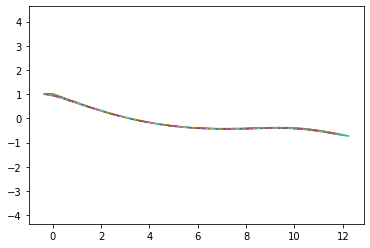

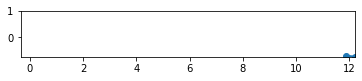

In [28]:
po = PointsOutput(points,system)
po.calc(states,t)
po.plot_time()
po.animate(fps = 30, movie_name='glider.mp4',lw=2,marker='o')

In [29]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(po.anim.to_html5_video())